In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import torch
import cv2
from PIL import Image
import albumentations as A
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from skimage import io, transform
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import  torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')


np.random.seed(0)
torch.manual_seed(0)

MessageError: ignored

In [ ]:
img = plt.imread("/content/drive/MyDrive/datasets/Flood area segmentation/Image/0.jpg")[:, :, :3]
mask = plt.imread("/content/drive/MyDrive/datasets/Flood area segmentation/Mask/0.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img)
axes[1].imshow(mask);

In [ ]:
class FloodDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, is_train=True, transform=False, channel=True):
        self.img_dir  = img_dir
        self.df = pd.read_csv(csv_file).iloc[1:, :]
        self.mask_dir = mask_dir
        self.channel = channel
        self.transform  = transform
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df.iloc[:, 0], self.df.iloc[:, 1], train_size=0.8)
        if is_train:
            self.images = self.X_train
            self.mask = self.y_train
        else:
            self.images = self.X_test
            self.mask = self.y_test
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img    = cv2.imread(os.path.join(self.img_dir, self.images.iloc[index]))
        mask   = cv2.imread(os.path.join(self.mask_dir, self.mask.iloc[index]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # img = cv2.bitwise_and(img, img,mask = cv2.Canny(img, 200,255))
        # img = np.divide(img, 255)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return T.Normalize(mean= [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])(img), T.Normalize(mean = 0.485, std = 0.224)(mask)

img_dir = "/content/drive/MyDrive/datasets/Flood area segmentation/Image"
mask_dir = "/content/drive/MyDrive/datasets/Flood area segmentation/Mask"
csv = "/content/drive/MyDrive/datasets/Flood area segmentation/metadata.csv"

PATCH_SIZE = 224
batch_size = 6
device = "cuda" if torch.cuda.is_available() else "cpu"

transforms = T.Compose([
    T.ToTensor(),
    T.Resize((PATCH_SIZE, PATCH_SIZE)),
    T.RandomCrop((PATCH_SIZE, PATCH_SIZE)),
    T.ColorJitter(),
    T.RandomVerticalFlip(),
    T.RandomHorizontalFlip(),
    # Otsu

]
)


def Otsu(img):
    mean = img.mean()
    img[img<= 0.5] = 0
    img[img>0.5] = 1
    return img

train_ds = FloodDataset(csv, img_dir, mask_dir, is_train=True,  transform=transforms)
test_ds = FloodDataset(csv, img_dir, mask_dir, is_train=False, transform=transforms)

train_dl = DataLoader(train_ds, batch_size = batch_size,shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size= batch_size, pin_memory=True)

for img, mask in train_dl:
    print(img.shape, mask.shape)
    break

## Image processing

In [ ]:
for img, mask in train_dl:
    print(img.shape, mask.shape)
    break
fig, axis = plt.subplots(1, 2, figsize=(7, 10))
axis[0].imshow(img[0].detach().numpy().swapaxes(0, 2))
axis[1].imshow(mask[0].detach().numpy().swapaxes(0, 2))

In [ ]:
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return IoU
iou = IoUScore()

# Defining the training and validation function and initializing parameters

In [ ]:
num_epochs = 10
accuracies = {"UNet":None, "ResNextUNet":None, "DeepLabV3+":None, "VIT":None}
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
ce_loss   = nn.BCEWithLogitsLoss()
iou_loss = lambda y, yhat: 1 - iou(y, yhat)
iou = IoUScore()
trainSteps = int(len(train_ds)/batch_size)
testSteps = int(len(test_ds)/batch_size)

In [ ]:
def train_model(model, traindl, testdl, loss_fn, epochs, learning_rate):

    train_loss = []
    test_loss = []
    test_iou = []
    train_iou = []

    opt = optim.SGD(model.parameters(), lr = learning_rate)
    loss_fn = loss_fn
    prev_test_loss = 100
    prev_train_loss = 100
    patience = 2
    trigger_times = 0
    model = model.to(device)

    try:
        for epoch in range(1, epochs+1):
            # Training loop
            model.train(True)
            correct = 0
            totalTrainLoss ,totalTestLoss, totalTrainIou, totalTestIou = 0, 0, 0, 0

            for X, y in tqdm(train_dl):
                X, y = X.to(device), y.to(device)
                opt.zero_grad()
                yhat = model(X)
                # loss = (1- iou(y, yhat))
        #         loss = loss_fn(y, yhat) * 0.4 + (1-iou(y, yhat))*0.6
                loss = loss_fn(y, yhat)
                iou_score = iou(y, yhat)
                totalTrainIou += iou_score.item()
                totalTrainLoss += loss.item()
                loss.backward()
                opt.step()
            avg_iou = totalTrainIou / trainSteps
            avg_loss = (totalTrainLoss/trainSteps)
            train_iou.append(avg_iou)
            train_loss.append(avg_loss)

            # Evaluation step
            model.train(False)

            with torch.no_grad():
                for X, y in tqdm(test_dl):
                    X, y = X.to(device), y.to(device)
                    yhat = model(X)
                    loss = loss_fn(y, yhat)
                    # loss = 1 - iou(y, yhat)
        #             loss = loss_fn(y, yhat) * 0.4 + (1-iou(y, yhat))*0.6
                    iou_score = iou(y, yhat)
                    totalTestIou += iou_score.item()
                    totalTestLoss += loss.item()
                avg_iou = (totalTestIou/testSteps)
                avg_loss = (totalTestLoss/testSteps)
                if avg_iou > 0.8:
                    torch.save(model, f"model_{round(avg_iou, 5)}.pth")
                test_loss.append(avg_loss)
                test_iou.append(avg_iou)
                print(f"Epoch:{epoch} train loss: {train_loss[-1]} \
             valid loss: {avg_loss} valid accuracy: {avg_iou} ")

    except KeyboardInterrupt:
        return model, train_loss, test_loss, train_iou, test_iou
    return model, train_loss, test_loss, train_iou, test_iou

# UNet

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()

        # Contracting Path
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Expansive Path
        self.ups = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2,
                    feature,
                    kernel_size=2,
                    stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Output Layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Contracting Path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)

        # Bottleneck
        x = self.bottleneck(x)

        # Expansive Path
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections.pop()
            x = torch.cat((x, skip_connection), dim=1)
            x = self.ups[i+1](x)

        # Output Layer
        x = self.final_conv(x)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return F.sigmoid(self.conv(x))
unet = UNet()

### Training UNet

In [ ]:
model, train_loss, test_loss, train_iou, test_iou = train_model(unet, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = ce_loss, learning_rate=0.001)
accuracies["UNet"] = np.mean(test_iou)

  0%|          | 0/39 [00:02<?, ?it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## ResNextUNet

In [ ]:
import torch
from torch import nn
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)

        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x


class ResNext50Unet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
#         e4 = self.dropout(e4)
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
#         d1 = self.dropout(d1)
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out
resnextUnet = ResNext50Unet()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 88.2MB/s]


## Training ResNextUnet

In [ ]:
model, train_loss, test_loss, train_iou, test_iou = train_model(resnextUnet, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = iou_loss, learning_rate=0.001)
accuracies["ResNextUNet"] = np.mean(test_iou)

  0%|          | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch:1 train loss: 0.4760902116173192              valid loss: 0.7403108014000787 valid accuracy: 0.37080030971103245 


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch:2 train loss: 0.3258759802893588              valid loss: 0.3539404604170058 valid accuracy: 0.7571706506941054 


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch:3 train loss: 0.29312414558310257              valid loss: 0.3040425247616238 valid accuracy: 0.8070685863494873 


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch:4 train loss: 0.2814763251103853              valid loss: 0.2593434386783176 valid accuracy: 0.8517676724327935 


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch:5 train loss: 0.2714732493224897              valid loss: 0.24069984753926596 valid accuracy: 0.8704112635718452 


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch:6 train loss: 0.27274407367957265              valid loss: 0.31244587898254395 valid accuracy: 0.7986652321285672 


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch:7 train loss: 0.2695093578413913              valid loss: 0.27997686465581256 valid accuracy: 0.8311342464552985 


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch:8 train loss: 0.2772347566328551              valid loss: 0.4319107598728604 valid accuracy: 0.6792003512382507 


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch:9 train loss: 0.27275004669239644              valid loss: 0.30695317851172554 valid accuracy: 0.8041579325993856 


100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch:10 train loss: 0.2575765267798775              valid loss: 0.2459941307703654 valid accuracy: 0.8651169803407457 


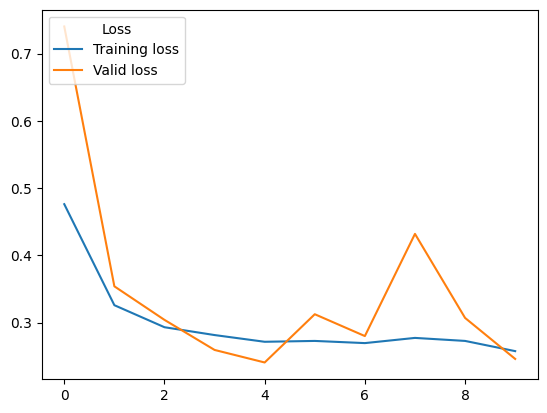

In [ ]:
plt.plot(train_loss,label='Training loss')
plt.plot(test_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

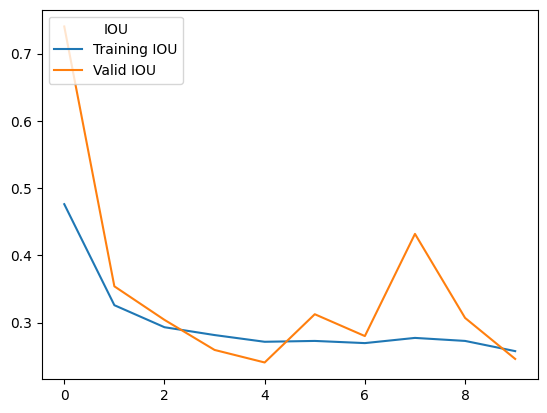

In [ ]:
plt.plot(train_loss,label='Training IOU')
plt.plot(test_loss, label='Valid IOU')
plt.legend(loc='upper left', title='IOU');

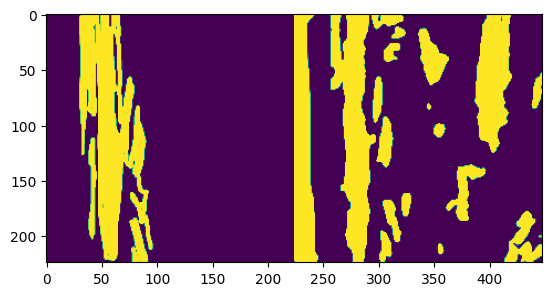

In [ ]:
res = model(img.to(device))
plt.imshow(np.hstack([mask[0].detach().cpu(), res[0].detach().cpu()]).swapaxes(0, 2))

### Getting the best model with highest accuracy

In [ ]:
from glob import glob
files = glob("*.pth")
accs= []
for f in files:
  accs.append(f.split(".")[1])
best_model_f = files[np.argmax(accs)]
files.remove(best_model_f)
for f in files:
    os.remove(f)

In [ ]:
best_model = torch.load(best_model_f).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


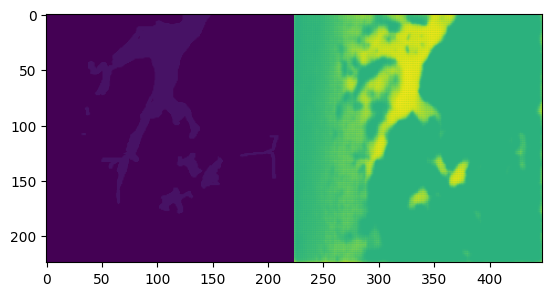

In [ ]:
for img, mask in test_dl:
    break
res = best_model(img.to(device))
plt.imshow(np.hstack([mask[0].detach().cpu(), res[0].detach().cpu()]).swapaxes(0, 2))

## Comparing with DeepLabV3+ and VIT


# VIT

In [ ]:
import torch.nn.functional as F
from torchvision.models import vit_b_16
class ViTSegmentationModel(nn.Module):
    def __init__(self, num_classes, image_size=224):
        super(ViTSegmentationModel, self).__init__()

        self.vit_backbone = vit_b_16(pretrained=True, image_size=image_size)

        # Modify the classification head for segmentation
        self.vit_backbone.heads = nn.Sequential(
            nn.Linear(self.vit_backbone.heads[0].in_features, 1024),
            nn.ReLU(),
            # nn.Dropout(),
            nn.Linear(1024, num_classes * image_size * image_size),
        )

        self.num_classes = num_classes
        self.image_size = image_size

    def forward(self, x):
        # Extract features from backbone
        features = self.vit_backbone(x)

        # Reshape features for segmentation mask output
        mask_logits = features.view(-1, self.num_classes, self.image_size, self.image_size)

        # Apply softmax activation to generate probabilities
        mask_probs = F.sigmoid(mask_logits)

        return mask_probs
vit = ViTSegmentationModel(1).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 77.8MB/s]


In [ ]:
!pip install vit_pytorch

In [ ]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=1):
        super(MyViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.patch_size = (chw[1] // n_patches, chw[2] // n_patches)
        self.input_d = chw[0] * self.patch_size[0] * self.patch_size[1]
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        self.mlp = nn.Linear(self.hidden_d, out_d)

    def forward(self, images):
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        for block in self.blocks:
            out = block(out)
        out = out[:, 0]
        out = self.mlp(out)
        return out

model = MyViT((3, 224, 224), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=1).to(device)

In [ ]:
model(img).shape

RuntimeError: ignored

## Training VIT Segmentation model

In [ ]:
lr = 0.03
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)


In [ ]:
model, train_loss, test_loss, train_iou, test_iou = train_model(vit, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn = ce_loss, learning_rate=lr)
accuracies["VIT"] = np.mean(test_iou)

  0%|          | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Epoch:1 train loss: nan              valid loss: nan valid accuracy: nan 


 56%|█████▋    | 22/39 [00:09<00:07,  2.28it/s]


# VIT from scratch

In [ ]:

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()

        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )
        # self.segment_out = nn.Conv2d(1, 1, kernel_size=3, padding = 1)


    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]
        out = self.mlp(out)
        # out = self.segment_out(out)

        return  out
model = MyViT((3, 224, 224), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=224*224).to(device)

In [ ]:
model(img).shape

RuntimeError: ignored

# DeepLab V3 plus

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=6, padding=6)
        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=12, padding=12)
        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=3, dilation=18, padding=18)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(x)
        conv3 = self.conv3(x)
        conv4 = self.conv4(x)
        conv5 = self.conv5(x)

        out = torch.cat((conv1, conv2, conv3, conv4, conv5), dim=1)
        return out


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, num_classes):
        super(Decoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, num_classes, kernel_size=1)

        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsample(x)

        return x


class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()

        # Encoder (ResNet-50)
        self.encoder = models.resnet50(pretrained=True)

        # ASPP module
        self.aspp = ASPP(2048, 256)

        # Decoder
        self.decoder = Decoder(256 * 5, 256, num_classes)

    def forward(self, x):
        # Encoder forward pass
        features = self.encoder.conv1(x)
        features = self.encoder.bn1(features)
        features = self.encoder.relu(features)
        features = self.encoder.maxpool(features)
        features = self.encoder.layer1(features)
        features = self.encoder.layer2(features)
        features = self.encoder.layer3(features)
        features = self.encoder.layer4(features)

        # ASPP module forward pass
        aspp_features = self.aspp(features)

        # Decoder forward pass
        output = self.decoder(aspp_features)
        output = torch.sigmoid(output)

        return output
deeplab = DeepLabV3Plus(1).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ASPPModule(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(ASPPModule, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
        self.bn4 = nn.BatchNorm2d(out_channels)

        self.conv5 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Branch 1: 1x1 convolution
        branch1 = self.conv1(x)
        branch1 = self.bn1(branch1)
        branch1 = self.relu(branch1)

        # Branch 2: 3x3 convolution with dilation rate 6
        branch2 = self.conv2(x)
        branch2 = self.bn2(branch2)
        branch2 = self.relu(branch2)

        # Branch 3: 3x3 convolution with dilation rate 12
        branch3 = self.conv3(x)
        branch3 = self.bn3(branch3)
        branch3 = self.relu(branch3)

        # Branch 4: 3x3 convolution with dilation rate 18
        branch4 = self.conv4(x)
        branch4 = self.bn4(branch4)
        branch4 = self.relu(branch4)

        # Branch 5: global average pooling and 1x1 convolution
        branch5 = F.adaptive_avg_pool2d(x, (1, 1))
        branch5 = self.conv5(branch5)
        branch5 = self.bn5(branch5)
        branch5 = self.relu(branch5)
        branch5 = F.interpolate(branch5, size=x.size()[2:], mode='bilinear', align_corners=True)

        # Concatenate branches and return
        output = torch.cat((branch1, branch2, branch3, branch4, branch5), dim=1)
        return output


class DeepLabv3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabv3Plus, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1))
        self.aspp = ASPPModule(in_channels=128, out_channels=256, dilation_rates=[6, 12, 18])
        self.decoder = nn.Sequential(
              nn.Conv2d(1280, 256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, 256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.Conv2d(256, num_classes, kernel_size=1)
          )

    def forward(self, x):
          # Backbone
        x = self.backbone(x)

        # ASPP
        x = self.aspp(x)

        # Decoder
        x = self.decoder(x)

        # Upsample to original image size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=True)

        return torch.sigmoid(x)


model = DeepLabv3Plus(1)

## Training DeepLabV3 plus model

In [ ]:
model, train_loss, test_loss, train_iou, test_iou = train_model(deeplab, train_dl,
                                    test_dl, epochs=num_epochs, loss_fn=dice_loss,  learning_rate=0.001)
accuracies["DeepLabV3+"] = np.mean(test_iou)

NameError: ignored

In [ ]:
from torch.utils.tensorboard import SummaryWriter
model = DeepLabv3Plus(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)

# Tensorboard logging
writer = SummaryWriter()

# Training loop
num_epochs = 30

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_dl):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = iou_loss(outputs, masks)
        # loss = criterion(outputs, masks)


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(test_dl):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = iou_loss(outputs, masks)
            # loss = criterion(outputs, masks)

            val_loss += loss.item() * images.size(0)

        val_loss /= len(test_ds)

    # Learning rate scheduling
    scheduler.step()

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(lr)

    # Tensorboard logging
    writer.add_scalar('Loss/Train', train_loss, epoch+1)
    writer.add_scalar('Loss/Val', val_loss, epoch+1)

# Close the tensorboard writer
writer.close()


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 1/30, Train Loss: 1.3629, Val Loss: 1.9022
0.001


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch 2/30, Train Loss: 1.2080, Val Loss: 1.3975
0.001


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Epoch 3/30, Train Loss: 1.3190, Val Loss: 1.4014
0.001


100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 4/30, Train Loss: 1.3135, Val Loss: -0.3935
0.001


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 5/30, Train Loss: 1.2817, Val Loss: 3.8351
0.001


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 6/30, Train Loss: 1.3064, Val Loss: 2.5874
0.001


100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch 7/30, Train Loss: 1.2903, Val Loss: 1.8736
0.001


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch 8/30, Train Loss: 1.3041, Val Loss: -1.8947
0.001


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 9/30, Train Loss: 1.2337, Val Loss: 2.7658
0.001


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 10/30, Train Loss: 1.2168, Val Loss: 2.6268
0.001


100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch 11/30, Train Loss: 1.3021, Val Loss: 1.8459
0.001


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch 12/30, Train Loss: 1.2058, Val Loss: 28.0427
0.001


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Epoch 13/30, Train Loss: 1.3213, Val Loss: 1.8982
0.001


100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 14/30, Train Loss: 1.2358, Val Loss: 1.6456
0.001


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 15/30, Train Loss: 1.2342, Val Loss: 1.1961
0.001


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 16/30, Train Loss: 1.2021, Val Loss: 1.6173
0.001


 77%|███████▋  | 30/39 [00:30<00:08,  1.09it/s]

In [ ]:
res.max(), res.min(), mask.max(), mask.min()

NameError: ignored

tensor(0.8521, device='cuda:0', grad_fn=<DivBackward0>)


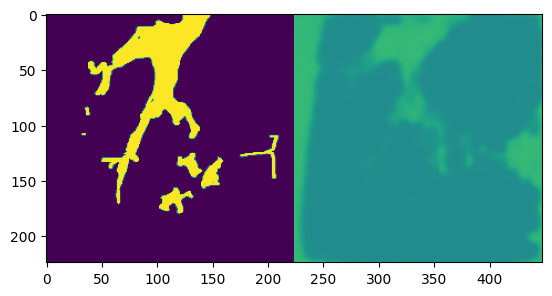

In [ ]:
for img, mask in test_dl:
  res = model(img.to(device))
  print(iou(mask.to(device), res.to(device)))
  break
plt.imshow(np.hstack([mask[0].detach().cpu().swapaxes(0,2), res[0].detach().cpu().swapaxes(0,2)]))
# plt.imshow(img[0].detach().cpu().swapaxes(0,2))
# plt.imshow(res[0].detach().cpu().swapaxes(0, 2))

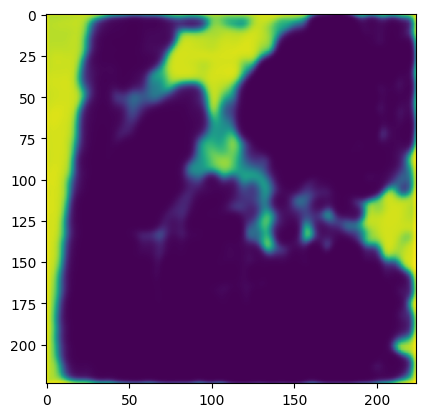

In [ ]:
# plt.imshow(res[0].detach().cpu().swapaxes(0,2))
# iou(mask[0].to(device), res[0].to(device))
plt.imshow(res[0].detach().cpu().permute(2, 1, 0))

In [ ]:
accuracies

{'UNet': None,
 'ResNextUNet': None,
 'DeepLabV3+': 1.5797081637004065,
 'VIT': None}

In [ ]:

def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]
dice_loss = DiceLoss()
dice_loss(mask.to(device) , res.to(device))

tensor(0.5000, device='cuda:0', grad_fn=<DivBackward0>)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


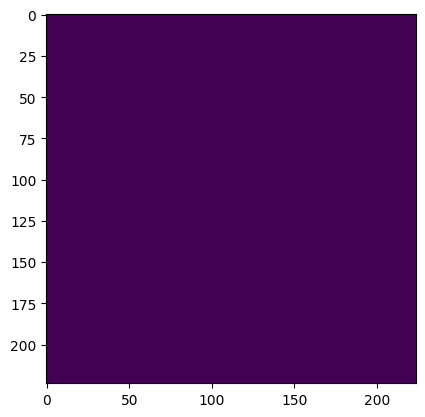

In [ ]:
for img, mask in test_dl:
  res = deeplab(img.to(device))
  break
plt.imshow(res[0].detach().cpu().swapaxes(0, 2))